In [1]:
import pandas as pd
df = pd.read_csv("retail_practice_data.csv")
df["sale_date"] = pd.to_datetime(df["sale_date"])
df = df.set_index("sale_date").sort_index()

In [2]:
df.head()

,store_id,product_id,product_name,category,unit_price,unit_cost,quantity_sold,inventory_level,sales_revenue,profit
sale_date,,,,,,,,,,
2024-01-01,Store_1,1002,Item_2,Food & Drink,45.51,25.10,1,42,45.51,20.41
2024-01-01,Store_5,1023,Item_23,Apparel,8.45,23.26,1,157,8.45,-14.81
2024-01-01,Store_5,1022,Item_22,Apparel,39.49,27.54,1,149,39.49,11.95
2024-01-01,Store_5,1021,Item_21,Apparel,10.96,8.02,3,147,32.88,8.82
2024-01-01,Store_5,1020,Item_20,Food & Drink,33.88,15.23,2,53,67.76,37.30


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 63424 entries, 2024-01-01 to 2025-06-30
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   store_id         63424 non-null  object 
 1   product_id       63424 non-null  int64  
 2   product_name     63424 non-null  object 
 3   category         63424 non-null  object 
 4   unit_price       63424 non-null  float64
 5   unit_cost        63424 non-null  float64
 6   quantity_sold    63424 non-null  int64  
 7   inventory_level  63424 non-null  int64  
 8   sales_revenue    63424 non-null  float64
 9   profit           63424 non-null  float64
dtypes: float64(4), int64(3), object(3)
memory usage: 5.3+ MB


In [4]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
product_id,63424.0,1015.494608,8.653103,1001.00,1008.00,1015.00,1023.00,1030.00
unit_price,63424.0,28.832869,11.307980,8.45,18.92,28.66,37.36,48.11
unit_cost,63424.0,15.617165,8.168913,2.60,7.78,15.23,23.48,27.58
quantity_sold,63424.0,1.909088,1.000794,1.00,1.00,2.00,2.00,5.00
inventory_level,63424.0,122.900148,44.577246,40.00,58.00,146.00,153.00,159.00
sales_revenue,63424.0,55.088496,37.805280,8.45,28.59,42.28,74.72,240.55
profit,63424.0,25.270012,29.251113,-74.05,6.83,20.78,37.30,165.10


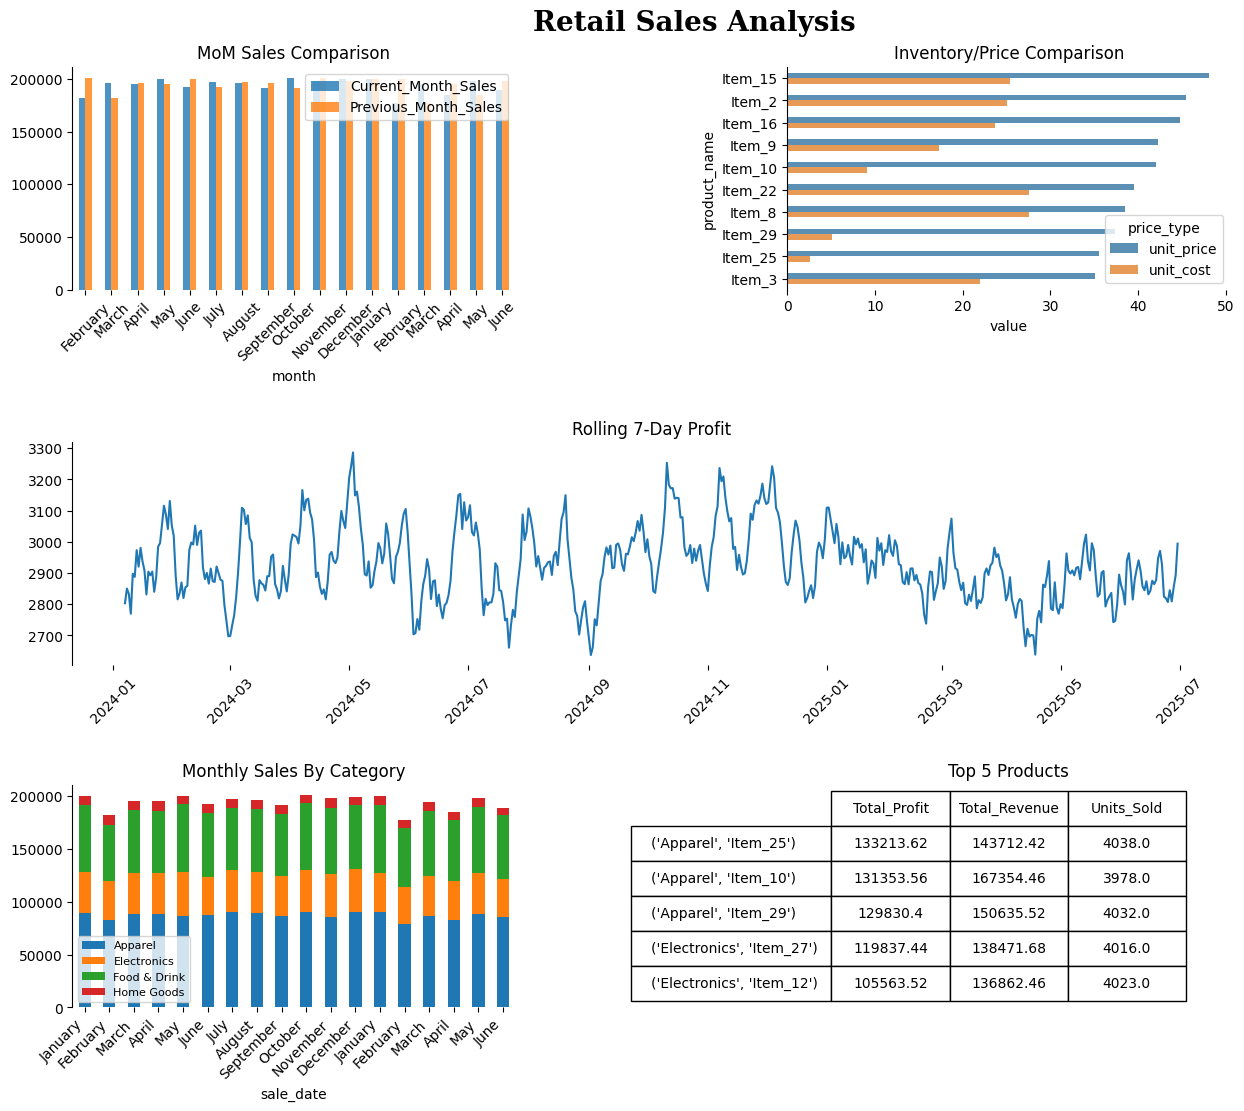

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
fig = plt.figure(layout = "constrained", figsize=(17,11))

gs = GridSpec(3,3, figure = fig,hspace=0.1, wspace=0.1)

fig.suptitle("Retail Sales Analysis", ha="right",
              fontsize = 20, fontweight = "bold", 
              fontfamily = "serif")

ax1 = plt.subplot(gs.new_subplotspec((0,0), colspan=1))
ax2 = plt.subplot(gs.new_subplotspec((0,1), colspan=1))
ax3 = plt.subplot(gs.new_subplotspec((1,0), colspan=2))
ax4 = plt.subplot(gs.new_subplotspec((2,0), colspan=1))
ax5 = plt.subplot(gs.new_subplotspec((2,1), colspan=1))

#================================================================================================================================================================================================================

# MoM SALES COMPARISON

monthly_sales = df['sales_revenue'].resample('ME').sum()
(pd.DataFrame({
     'Current_Month_Sales': monthly_sales,
     'Previous_Month_Sales': monthly_sales.shift(1)
}).iloc[1:].reset_index()
    .assign(month=lambda x: x["sale_date"]
    .dt
    .month_name())
    .set_index("month")
    .drop(columns="sale_date",axis = 1)
    .plot
    .bar(ax = ax1, alpha = 0.8, width = 0.5)
)

ax1.tick_params(axis="x", rotation = 45)

ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.spines["bottom"].set_visible(False)
ax1.set_title("MoM Sales Comparison")
ax1.legend()

#================================================================================================================================================================================================================

# INVENTORY/PRICE COMPARISON

inventory_price_comparison = (df.groupby(
    "product_name")[["unit_price", "unit_cost"]]
    .mean()
    .reset_index()
    .nlargest(columns= "unit_price", n=10)
    .melt(id_vars="product_name", value_vars=["unit_price", "unit_cost"], var_name="price_type", value_name="value")
)

sns.barplot(inventory_price_comparison, x = "value", y="product_name", hue="price_type", alpha = 0.8, ax=ax2, width=0.5)

ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
ax2.spines["bottom"].set_visible(False)
ax2.spines["top"].set_visible(False)

ax2.set_title("Inventory/Price Comparison")

#================================================================================================================================================================================================================

# ROLLING 7-DAY PROFIT

daily_profit = df['profit'].resample('D').sum()
series_rolling_profit = daily_profit.rolling(window=7).mean().dropna()

ax3.plot(series_rolling_profit)
ax3.tick_params(axis = "x", rotation = 45)

ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)

ax3.spines["bottom"].set_visible(False)

ax3.spines["top"].set_visible(False)

ax3.set_title("Rolling 7-Day Profit")

#================================================================================================================================================================================================================

# MONTHLY SALES BY CATEGORY

df_monthly_category_revenue = df.groupby(
    ['category', pd.Grouper(freq='ME')]
)['sales_revenue'].sum().unstack(level='category').fillna(0)
month_labels = df_monthly_category_revenue.index.strftime('%B')    
df_monthly_category_revenue.plot(kind = "bar", stacked = True, ax = ax4)

ax4.set_xticklabels(month_labels, rotation = 45, ha="right");


ax4.spines["top"].set_visible(False)
ax4.spines["right"].set_visible(False)

ax4.spines["bottom"].set_visible(False)

ax4.set_title("Monthly Sales By Category")
ax4.legend(fontsize=8)

#===============================================================================================================================================================================================================

# TOP 5 PRODUCTS

df_product_profit = df.groupby(['category', 'product_name']).agg(
    Total_Profit=('profit', 'sum'),
    Total_Revenue=('sales_revenue', 'sum'),
    Units_Sold=('quantity_sold', 'sum')
)


series_top_5_index = df_product_profit['Total_Profit'].nlargest(5).index
df_top_5_products = df_product_profit.loc[series_top_5_index].sort_values(
    by='Total_Profit', ascending=False)

df_top_5_products = round(df_top_5_products, 2)



table = ax5.table(cellText=df_top_5_products.values,
          rowLabels=df_top_5_products.index,
          colLabels=df_top_5_products.columns,
          loc= "center",
          cellLoc="center",
          #rowColours="RyGb"
          )

ax5.axis("off")

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(0.8, 2.5)

ax5.set_title("Top 5 Products")

fig.savefig("business_analysis.pdf")
